# Recycling with Deep Learning: A CNN-Based Approach to Waste Classification
### By : Ching Hsuan Lin, Kayla Candice Huang, Pin Hao Pan, Zhe Yu Lin

# Motivation

According to California Review Management, roughly 1.8 million acres of U.S. land are consumed by landfills, yet only 32.1 % of American waste is recycled or composted—mainly because contamination (mixing general trash or food-soiled items with recyclables) often renders whole batches unrecyclable, driving up greenhouse-gas emissions, polluting soil and groundwater, and forcing municipalities to spend more on manual sorting or rejected loads. To address this, we propose a fine-grained CNN-based image classifier that can be embedded in smart waste bins to automatically identify and guide proper disposal. Deployed in public spaces, campuses, industrial facilities, and residential complexes, this system pre-sorts materials at scale, cuts contamination, lowers operational costs, and ultimately strengthens urban recycling infrastructure for a smaller environmental footprint.

# Data Dictionary

| class_name     | description                                                               |
|----------------|---------------------------------------------------------------------------|
| General Waste  | Non-recyclable or contaminated items that cannot be composted or recycled. |
| Organic Waste  | Biodegradable, compostable materials of biological origin.                |
| Paper          | Clean, dry paper products free of plastic film, wax, or heavy contamination. |
| Plastic        | Rinse-clean plastic containers and products (labels removed when possible). |
| Glass          | Empty, rinse-clean glass bottles and jars (lids removed when possible).                 |
| Metal          | Rinse-clean metal cans and containers.            |


# Executive Summary

In this project, we set out to build an automated system for classifying everyday waste into six categories—General Waste, Organic, Paper, Plastic, Glass, and Metal—using deep learning. We began by collecting our own dataset of garbage images under real-world conditions, converting all photos to JPEG format at a uniform 224×224 resolution, and applying standard data augmentations (flips and rotations) to improve robustness.  

Our first approach was a custom convolutional neural network trained from scratch. We started with basic augmentations such as random flips, rotations, and zooms, and used three Conv2D layers with the RMSprop optimizer. Building on this structure, we also experimented with adding a fourth convolutional layer, incorporating dropout to prevent overfitting, and applying stronger augmentations like random translations to each self-constructed model.  

To leverage richer feature representations, we then turned to transfer learning. A ResNet50 model pre-trained on ImageNet produced more balanced predictions but uniformly low confidence scores across all classes—suggesting that, while it recognized differences, it could not decisively distinguish among our six waste types, resulting in lower test accuracy.  

Finally, we adopted MobileNetV2, a lightweight architecture better suited for small datasets. Without CutMix augmentation, our MobileNetV2 model already outperformed ResNet50 in overall validation accuracy and confidence. Introducing CutMix—where image patches and labels are mixed during training—further reduced misclassifications, particularly between visually similar classes like Plastic and Glass. In the end, we found that MobileNetV2 delivered the best performance.




#Data Preprocessing

Before we fed the images into our model, we went through a standardized preprocessing pipeline.  
1.First, we filtered the file formats by converting all images to JPEG, to avoid any hidden errors from inconsistent formats.  
2.Then, we corrected the orientation to make sure that sideways or upside-down photos wouldn't affect the model's learning.  
3.Next, we converted the images to RGB mode, removing any transparency issues that could interfere when saving as JPEG.  
4.After that, we resize all images—scaling them down if they were larger than 224 by 224 pixels but making sure not to upscale small ones.  
5.For non-square images, we centered them on a white background to maintain the correct aspect ratio without distortion.  
6.Finally, we unified the file names to standardize the dataset and make future processing more efficient.  


In [ ]:
import tensorflow as tf
import numpy as np
import random

SEED = 100
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
# !pip install pyheif
import os
from PIL import Image, ImageOps

# Input and output folder paths — please update according to your actual setup
input_folder = "/content/drive/MyDrive/BA 865 Project/garbage_data/Recyclables_Plastic(114)"
output_folder = "/content/drive/MyDrive/BA 865 Project/garbage_data/Recyclables_Plastic(114)_1"
os.makedirs(output_folder, exist_ok=True)

counter = 1  # Initialize a counter starting from 1

for filename in os.listdir(input_folder):
    name, ext = os.path.splitext(filename)
    ext = ext.lower()

    # Process only files with .jpg or .jpeg extensions
    if ext not in [".jpg", ".jpeg"]:
        continue

    input_path = os.path.join(input_folder, filename)

    # Generate a new filename using the counter, e.g., Plastic_1.jpeg, Plastic_2.jpeg, ...
    new_filename = f"Plastic_{counter}.jpeg"
    output_path = os.path.join(output_folder, new_filename)

    try:
        image = Image.open(input_path)
        image = ImageOps.exif_transpose(image)  # Correct image orientation based on EXIF data
        image = image.convert("RGB")  # JPEG does not support transparency

        # Calculate scaling ratio without enlarging small images (scale only if larger than 224)
        old_w, old_h = image.size
        target_w, target_h = 224, 224
        ratio = min(1.0, min(target_w / old_w, target_h / old_h))
        new_w = int(old_w * ratio)
        new_h = int(old_h * ratio)
        resized = image.resize((new_w, new_h), Image.Resampling.LANCZOS)

        # Center the resized image on a white background (255, 255, 255)
        new_img = Image.new("RGB", (target_w, target_h), (255, 255, 255))
        left = (target_w - new_w) // 2
        top = (target_h - new_h) // 2
        new_img.paste(resized, (left, top))

        new_img.save(output_path, "JPEG")
        print(f"Success: {filename} → {new_filename}")

        counter += 1  # Increment counter after successful processing
    except Exception as e:
        print(f"Failed: {filename} failed: {e}")

print("Finished!")

# Train, Validation, Test Split

In [ ]:
import os
import random
import shutil

# origial folder
source_folder = "/content/drive/MyDrive/BA 865 Project/garbage_data_converted/Recyclables_Plastic(114)_1"

# target folder
train_folder = "/content/drive/MyDrive/BA 865 Project/train/Plastic"
val_folder = "/content/drive/MyDrive/BA 865 Project/validation/Plastic"
test_folder = "/content/drive/MyDrive/BA 865 Project/test/Plastic"

# make sure all files are there
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# set the proportion
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# get all file paths
images = [f for f in os.listdir(source_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(images)

# count the amount of pictures
total = len(images)
train_end = int(total * train_ratio)
val_end = train_end + int(total * val_ratio)

# split the dataset
train_imgs = images[:train_end]
val_imgs = images[train_end:val_end]
test_imgs = images[val_end:]

# Copy images from the source folder to a specified destination folder
def copy_images(img_list, dest_folder):
    for img in img_list:
        src_path = os.path.join(source_folder, img)
        dst_path = os.path.join(dest_folder, img)
        shutil.copy(src_path, dst_path)


copy_images(train_imgs, train_folder)
copy_images(val_imgs, val_folder)
copy_images(test_imgs, test_folder)

print(f"Total: {total} images")
print(f"Train: {len(train_imgs)}, Validation: {len(val_imgs)}, Test: {len(test_imgs)}")


# Read the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

base_dir = '/content/drive/MyDrive/BA 865 Project'

train_dataset = image_dataset_from_directory(
    base_dir + "/train/",
    image_size=(224, 224),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    base_dir + "/validation/",
    image_size=(224, 224),
    batch_size=32)


Found 470 files belonging to 6 classes.
Found 101 files belonging to 6 classes.


# Model Evaluation Function

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4850e5d4c460b66b8e980fd12cb6811bb0564e9324aa5cb900c0092b41b77655
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow import keras

def explain_with_lime(
    model,
    img_path,
    image_size=(224, 224),
    top_labels=1,
    hide_color=0,
    num_samples=500,
    num_features=5
):

    # 1. Load and preprocess the image
    img = Image.open(img_path).convert('RGB')
    img = img.resize(image_size)
    x = np.array(img)

    # 2. Define prediction function for LIME
    def predict_fn(imgs):
        imgs = np.array(imgs).astype(np.float32) / 255.0
        return model.predict(imgs)

    # 3. Create a LIME image explainer and generate explanation
    explainer = lime_image.LimeImageExplainer()
    exp = explainer.explain_instance(
        image=x,
        classifier_fn=predict_fn,
        top_labels=top_labels,
        hide_color=hide_color,
        num_samples=num_samples
    )

    # 4. Get regions that positively contribute to the prediction
    label = exp.top_labels[0]
    temp, mask = exp.get_image_and_mask(
        label,
        positive_only=True,
        num_features=num_features,
        hide_rest=False
    )

    # 5. Plot original image and LIME explanation
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(x)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(mark_boundaries(temp / 255.0, mask))
    axes[1].set_title(f"LIME for class {label}")
    axes[1].axis("off")

    plt.tight_layout()
    return fig

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def predict_and_plot(
    model,
    img_path,
    class_names,
    img_size=(224, 224),
    normalize=True
):

    # 1. Load and preprocess the image
    img = Image.open(img_path).convert("RGB")
    img_resized = img.resize(img_size)
    x = np.array(img_resized, dtype=np.float32)
    if normalize:
        x /= 255.0
    x = np.expand_dims(x, axis=0)  # Shape becomes (1, H, W, 3)

    # 2. Make prediction
    probs = model.predict(x)[0]     # Shape = (num_classes,)
    idx   = np.argmax(probs)
    label = class_names[idx]
    conf  = probs[idx]

    # 3. Plot the result
    fig = plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Predicted: {label}\nConfidence: {conf:.2%}")
    plt.axis("off")
    plt.tight_layout()

    return fig, label, conf

# Selfbuilt Model V1

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers


# --- Basic settings ---
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 6
AUTOTUNE = tf.data.AUTOTUNE
base_dir = "/content/drive/MyDrive/BA 865 Project"

# --- Load datasets ---
train_dataset_raw = image_dataset_from_directory(
    base_dir + "/train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
val_dataset_raw = image_dataset_from_directory(
    base_dir + "/validation",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# --- Rescale only once globally ---
def preprocess_image(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

# --- Apply preprocessing and optimize data pipeline ---
train_dataset = train_dataset_raw.map(preprocess_image).cache().shuffle(1000, seed=SEED)
val_dataset = val_dataset_raw.map(preprocess_image).cache().prefetch(AUTOTUNE)

# --- Standard augmentation ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

# --- Model definition ---
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# --- Compile model ---
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# --- Model summary ---
model.summary()

# --- Training ---
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset
)

# --- Save model ---
model.save('/content/drive/MyDrive/BA 865 Project/bestv1.h5')

Found 470 files belonging to 6 classes.
Found 101 files belonging to 6 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │       519,174 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 612,422 (2.34 MB)

 Trainable params: 612,422 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.1886 - loss: 3.2505 - val_accuracy: 0.2376 - val_loss: 1.7248
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.2716 - loss: 1.5665 - val_accuracy: 0.3861 - val_loss: 1.4877
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3054 - loss: 1.5465 - val_accuracy: 0.3564 - val_loss: 1.4391
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3817 - loss: 1.4633 - val_accuracy: 0.3960 - val_loss: 1.4069
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3919 - loss: 1.4635 - val_accuracy: 0.4059 - val_loss: 1.3479
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3905 - loss: 1.3905 - val_accuracy: 0.4257 - val_loss: 1.3430
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3946 - loss: 1.4168 - val_accuracy: 0.4257 - val_loss: 1.3436
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3960 - loss: 1.3617 - val_accuracy: 0.4950 - 

### Plot Accuracy Over Training in Training vs. Validation Sample

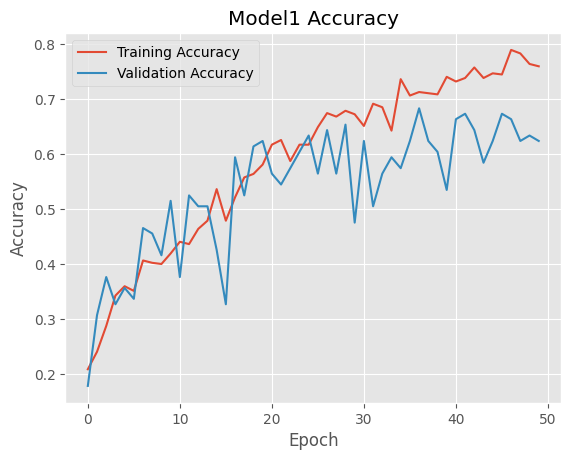

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Add plotting statements
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model1 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plot Loss Over Training in Training vs. Validation Sample

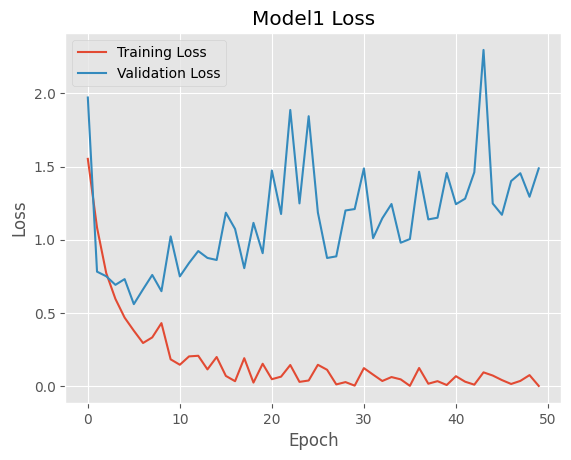

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model1 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model V1 Evaluate

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━

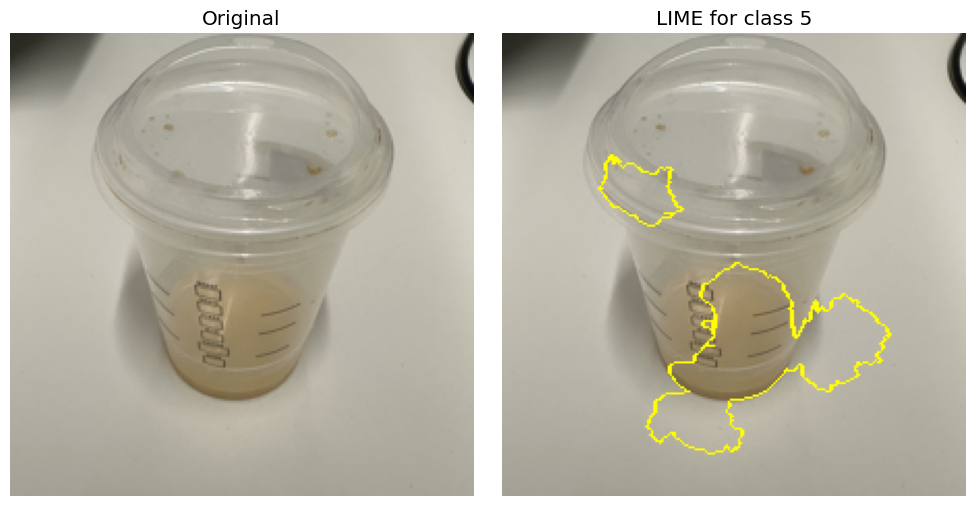

In [ ]:
# Load any pre-trained model
model = keras.models.load_model('/content/drive/MyDrive/BA 865 Project/bestv1.h5')

# Call the function and display the result
fig = explain_with_lime(
    model,
    img_path=base_dir + '/test3.jpeg',
    image_size=(224, 224),
    top_labels=1,
    hide_color=0,
    num_samples=500,
    num_features=5
)
fig.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Predicted Class: Plastic, Confidence: 53.48%


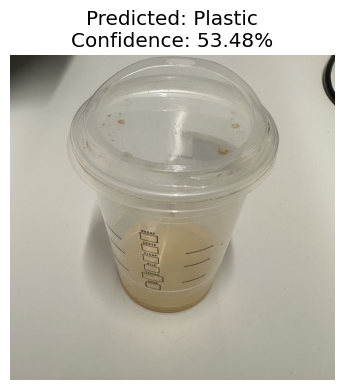

In [ ]:
# Parameter settings
MODEL_PATH  = "/content/drive/MyDrive/BA 865 Project/bestv1.h5"
CLASS_NAMES = ['General Waste', 'Glass', 'Metal', 'Organic Waste', 'Paper', 'Plastic']
IMG_PATH    = "/content/drive/MyDrive/BA 865 Project/test3.jpeg"

# Load the model
model = keras.models.load_model(MODEL_PATH)

# Call the function
fig, pred_label, confidence = predict_and_plot(
    model=model,
    img_path=IMG_PATH,
    class_names=CLASS_NAMES,
    img_size=(224, 224),
    normalize=True
)

# Display the image
fig.show()

# If you want to use the prediction result in the code
print(f"Predicted Class: {pred_label}, Confidence: {confidence:.2%}")

# Selfbuilt Model v2

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers


# --- Basic settings ---
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 6
AUTOTUNE = tf.data.AUTOTUNE
base_dir = "/content/drive/MyDrive/BA 865 Project"

# --- Load datasets ---
train_dataset_raw = image_dataset_from_directory(
    base_dir + "/train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
val_dataset_raw = image_dataset_from_directory(
    base_dir + "/validation",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# --- Rescale only once globally ---
def preprocess_image(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

# --- Apply preprocessing and optimize data pipeline ---
train_dataset = train_dataset_raw.map(preprocess_image).cache().shuffle(1000, seed=SEED)
val_dataset = val_dataset_raw.map(preprocess_image).cache().prefetch(AUTOTUNE)

# --- Standard augmentation ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

# --- Model definition ---
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# --- Compile model ---
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# --- Model summary ---
model.summary()

# --- Training ---
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset
)

# --- Save model ---
model.save('/content/drive/MyDrive/BA 865 Project/bestv2.h5')

Found 470 files belonging to 6 classes.
Found 101 files belonging to 6 classes.


Model: "functional_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │       221,190 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609,606 (2.33 MB)

 Trainable params: 609,606 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.1843 - loss: 2.0993 - val_accuracy: 0.1782 - val_loss: 1.7699
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.2639 - loss: 1.6342 - val_accuracy: 0.3267 - val_loss: 1.4947
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.2939 - loss: 1.5506 - val_accuracy: 0.2871 - val_loss: 1.4728
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3452 - loss: 1.4491 - val_accuracy: 0.3366 - val_loss: 1.4111
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4314 - loss: 1.3594 - val_accuracy: 0.3960 - val_loss: 1.3715
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3956 - loss: 1.4002 - val_accuracy: 0.3663 - val_loss: 1.4399
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3640 - loss: 1.4432 - val_accuracy: 0.3663 - val_loss: 1.6495
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4580 - loss: 1.3577 - val_accuracy: 0.4950 - 

### Plot Accuracy Over Training in Training vs. Validation Sample

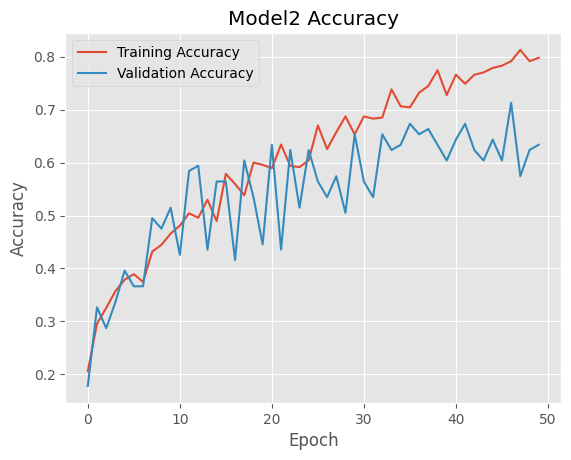

In [ ]:
plt.style.use('ggplot')

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plot Loss Over Training in Training vs. Validation Sample

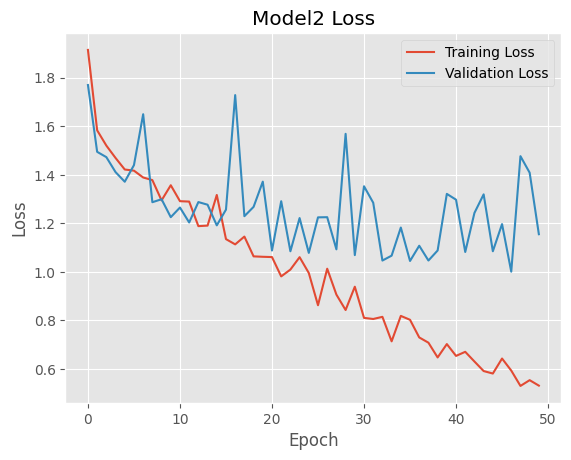

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model V2 Evaluate

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

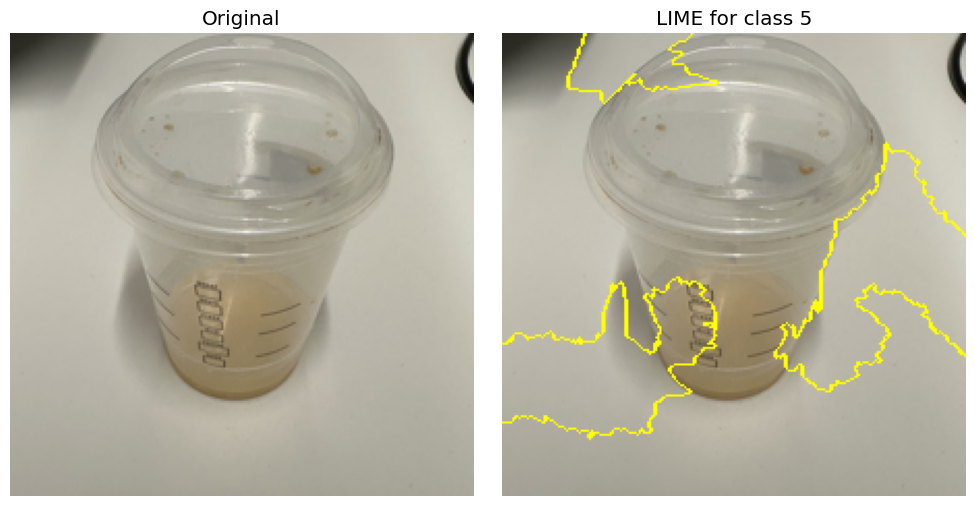

In [ ]:
# Load any pre-trained model
model = keras.models.load_model('/content/drive/MyDrive/BA 865 Project/bestv2.h5')

# Call the function and display the result
fig = explain_with_lime(
    model,
    img_path=base_dir + '/test3.jpeg',
    image_size=(224, 224),
    top_labels=1,
    hide_color=0,
    num_samples=500,
    num_features=5
)
fig.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Predicted Class: Metal, Confidence: 32.57%


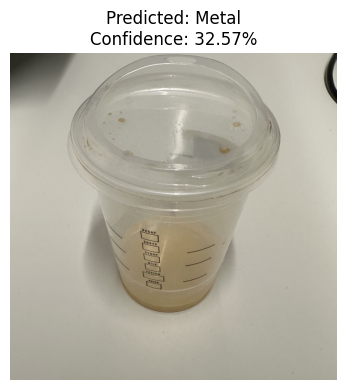

In [ ]:
# Parameter settings
MODEL_PATH  = "/content/drive/MyDrive/BA 865 Project/bestv2.h5"
CLASS_NAMES = ['General Waste', 'Glass', 'Metal', 'Organic Waste', 'Paper', 'Plastic']
IMG_PATH    = "/content/drive/MyDrive/BA 865 Project/test3.jpeg"

# Load the model
model = keras.models.load_model(MODEL_PATH)

# Call the function
fig, pred_label, confidence = predict_and_plot(
    model=model,
    img_path=IMG_PATH,
    class_names=CLASS_NAMES,
    img_size=(224, 224),
    normalize=True
)

# Display the image
fig.show()

# If you want to use the prediction result in the code
print(f"Predicted Class: {pred_label}, Confidence: {confidence:.2%}")

# Selfbuilt Model V3

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers


# --- Basic settings ---
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 6
AUTOTUNE = tf.data.AUTOTUNE
base_dir = "/content/drive/MyDrive/BA 865 Project"

# --- Load datasets ---
train_dataset_raw = image_dataset_from_directory(
    base_dir + "/train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
val_dataset_raw = image_dataset_from_directory(
    base_dir + "/validation",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# --- Rescale only once globally ---
def preprocess_image(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

# --- Apply preprocessing and optimize data pipeline ---
train_dataset = train_dataset_raw.map(preprocess_image).cache().shuffle(1000, seed=SEED)
val_dataset = val_dataset_raw.map(preprocess_image).cache().prefetch(AUTOTUNE)

# --- Standard augmentation ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

# --- Model definition ---
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# --- Compile model ---
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# --- Model summary ---
model.summary()

# --- Training ---
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset
)

# --- Save model ---
model.save('/content/drive/MyDrive/BA 865 Project/bestv3.h5')

Found 470 files belonging to 6 classes.
Found 101 files belonging to 6 classes.


Model: "functional_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │       221,190 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609,606 (2.33 MB)

 Trainable params: 609,606 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.1940 - loss: 2.3034 - val_accuracy: 0.2871 - val_loss: 1.7728
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.2651 - loss: 2.0099 - val_accuracy: 0.3366 - val_loss: 1.5211
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3117 - loss: 1.5465 - val_accuracy: 0.3960 - val_loss: 1.4405
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3058 - loss: 1.5401 - val_accuracy: 0.3663 - val_loss: 1.4216
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3246 - loss: 1.5105 - val_accuracy: 0.3861 - val_loss: 1.5020
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3701 - loss: 1.4830 - val_accuracy: 0.3861 - val_loss: 1.4069
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3219 - loss: 1.5285 - val_accuracy: 0.3663 - val_loss: 1.4208
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4081 - loss: 1.4737 - val_accuracy: 0.3960 - v

## Plot Accuracy Over Training in Training vs. Validation Sample

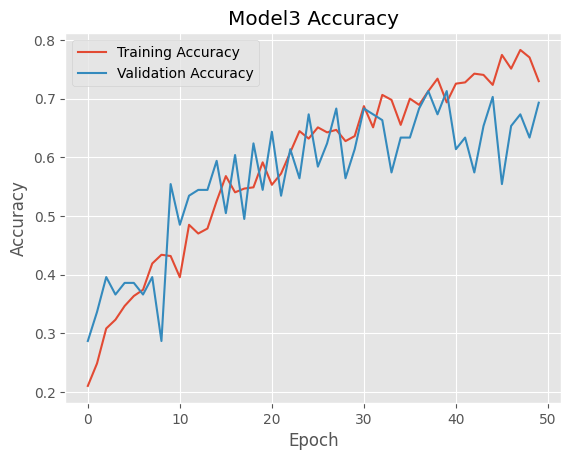

In [ ]:
plt.style.use('ggplot')

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model3 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Plot Loss Over Training in Training vs. Validation Sample

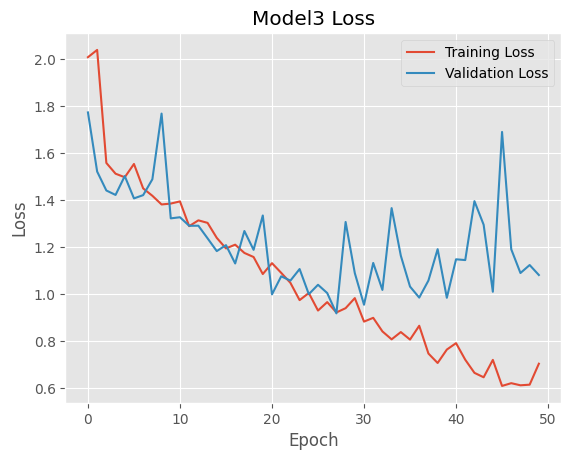

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model3 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## V3 Evaluate

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━

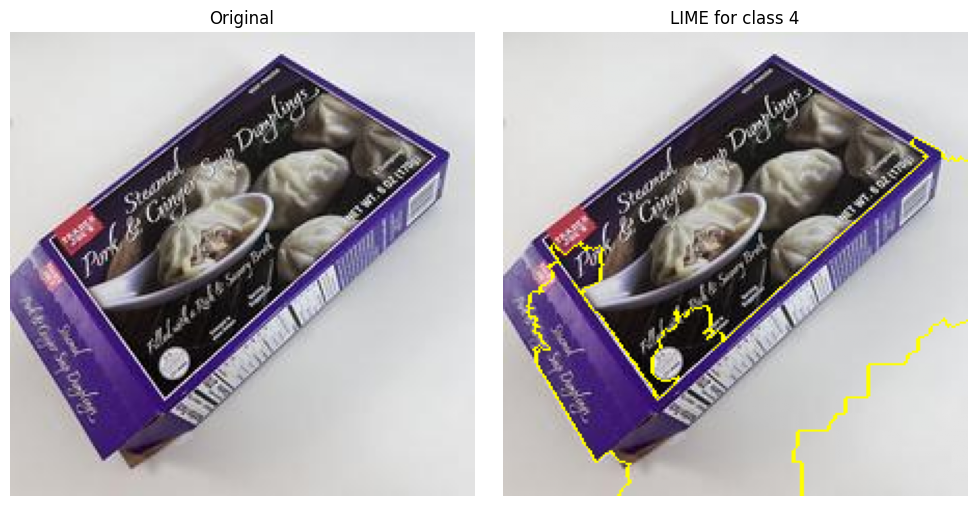

In [ ]:
# Load any pre-trained model
model = keras.models.load_model('/content/drive/MyDrive/BA 865 Project/bestv3.h5')

# Call the function and display the result
fig = explain_with_lime(
    model,
    img_path=base_dir + '/Paper_16.jpeg',
    image_size=(224, 224),
    top_labels=1,
    hide_color=0,
    num_samples=500,
    num_features=5
)
fig.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Predicted Class: Plastic, Confidence: 70.36%


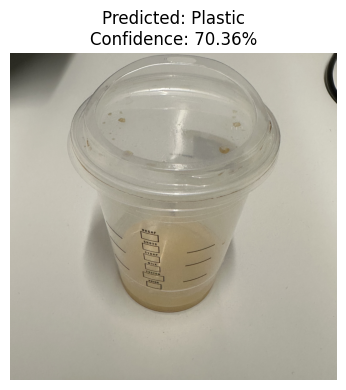

In [ ]:
# Parameter settings
MODEL_PATH  = "/content/drive/MyDrive/BA 865 Project/bestv3.h5"
CLASS_NAMES = ['General Waste', 'Glass', 'Metal', 'Organic Waste', 'Paper', 'Plastic']
IMG_PATH    = "/content/drive/MyDrive/BA 865 Project/test3.jpeg"

# Load the model
model = keras.models.load_model(MODEL_PATH)

# Call the function
fig, pred_label, confidence = predict_and_plot(
    model=model,
    img_path=IMG_PATH,
    class_names=CLASS_NAMES,
    img_size=(224, 224),
    normalize=True
)

# Display the image
fig.show()

# If you want to use the prediction result in the code
print(f"Predicted Class: {pred_label}, Confidence: {confidence:.2%}")

# Selfbuilt Model V4

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers


# --- Basic settings ---
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 6
AUTOTUNE = tf.data.AUTOTUNE
base_dir = "/content/drive/MyDrive/BA 865 Project"

# --- Load datasets ---
train_dataset_raw = image_dataset_from_directory(
    base_dir + "/train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
val_dataset_raw = image_dataset_from_directory(
    base_dir + "/validation",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# --- Rescale only once globally ---
def preprocess_image(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

# --- Apply preprocessing and optimize data pipeline ---
train_dataset = train_dataset_raw.map(preprocess_image).cache().shuffle(1000, seed=SEED)
val_dataset = val_dataset_raw.map(preprocess_image).cache().prefetch(AUTOTUNE)

# --- Standard augmentation ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1)
])

# --- Model definition ---
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# --- Compile model ---
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# --- Model summary ---
model.summary()

# --- Training ---
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset
)

# --- Save model ---
model.save('/content/drive/MyDrive/BA 865 Project/bestv4.h5')

Found 470 files belonging to 6 classes.
Found 101 files belonging to 6 classes.


Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │       221,190 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609,606 (2.33 MB)

 Trainable params: 609,606 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.1976 - loss: 2.1362 - val_accuracy: 0.1584 - val_loss: 1.7649
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.2415 - loss: 1.6643 - val_accuracy: 0.3267 - val_loss: 1.5761
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3351 - loss: 1.5244 - val_accuracy: 0.3267 - val_loss: 1.5115
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3417 - loss: 1.5123 - val_accuracy: 0.4158 - val_loss: 1.4168
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.2871 - loss: 1.7327 - val_accuracy: 0.3069 - val_loss: 1.7684
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3483 - loss: 1.4666 - val_accuracy: 0.4455 - val_loss: 1.3573
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3890 - loss: 1.3782 - val_accuracy: 0.3861 - val_loss: 1.4490
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4235 - loss: 1.4248 - val_accuracy: 0.3267 - v

### Plot Accuracy Over Training in Training vs. Validation Sample

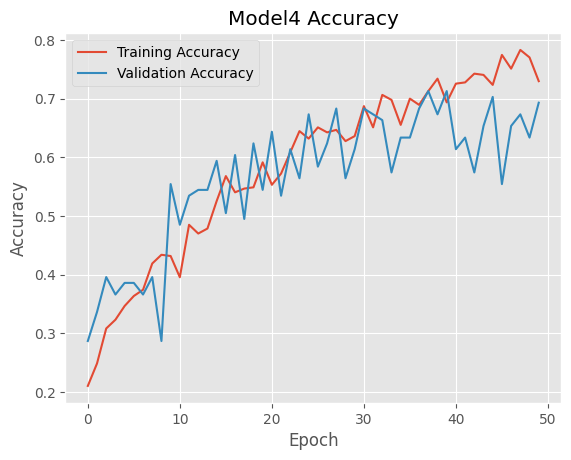

In [ ]:
plt.style.use('ggplot')

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model4 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plot Loss Over Training in Training vs. Validation Sample

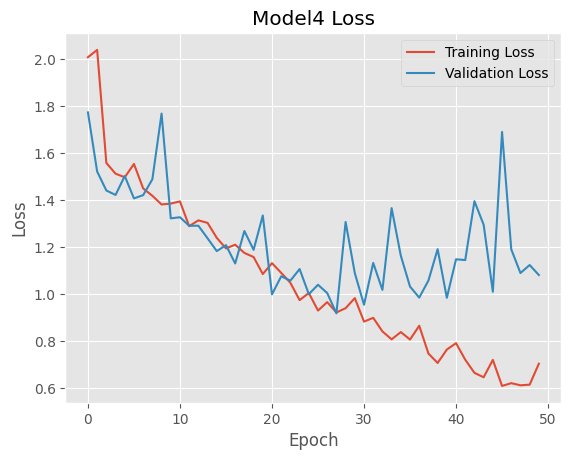

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model4 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model V4 Evaluate

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

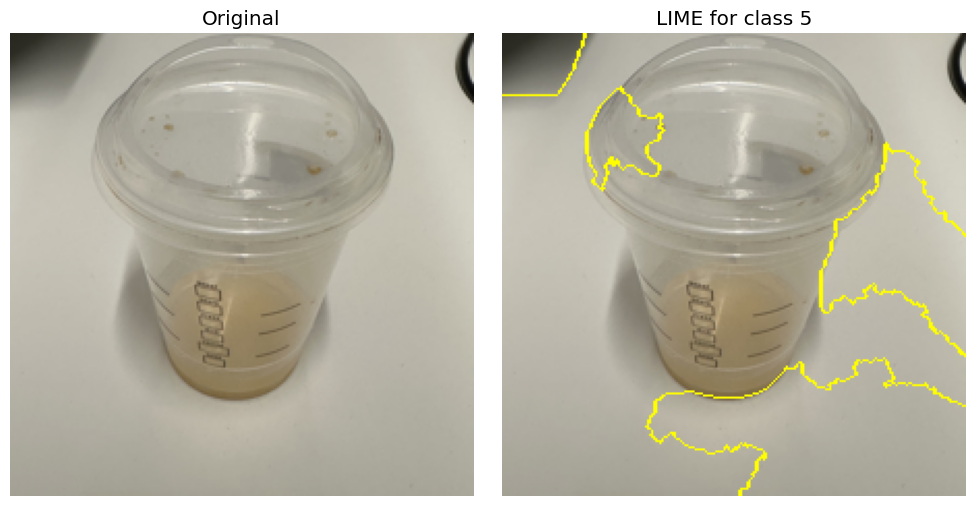

In [ ]:
# Load any pre-trained model
model = keras.models.load_model('/content/drive/MyDrive/BA 865 Project/bestv4.h5')

# Call the function and display the result
fig = explain_with_lime(
    model,
    img_path=base_dir + '/test3.jpeg',
    image_size=(224, 224),
    top_labels=1,
    hide_color=0,
    num_samples=500,
    num_features=5
)
fig.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Predicted Class: Plastic, Confidence: 41.84%


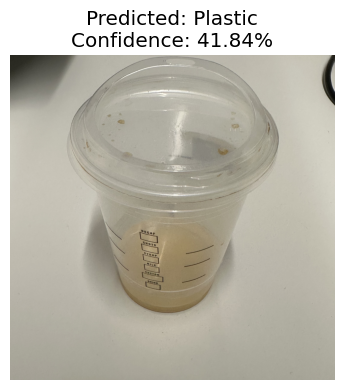

In [ ]:
# Parameter settings
MODEL_PATH  = "/content/drive/MyDrive/BA 865 Project/bestv4.h5"
CLASS_NAMES = ['General Waste', 'Glass', 'Metal', 'Organic Waste', 'Paper', 'Plastic']
IMG_PATH    = "/content/drive/MyDrive/BA 865 Project/test3.jpeg"

# Load the model
model = keras.models.load_model(MODEL_PATH)

# Call the function
fig, pred_label, confidence = predict_and_plot(
    model=model,
    img_path=IMG_PATH,
    class_names=CLASS_NAMES,
    img_size=(224, 224),
    normalize=True
)

# Display the image
fig.show()

# If you want to use the prediction result in the code
print(f"Predicted Class: {pred_label}, Confidence: {confidence:.2%}")

# Pretrained Model - ResNet50

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- Basic settings ---
IMG_SIZE    = 224
BATCH_SIZE  = 32
NUM_CLASSES = 6
AUTOTUNE    = tf.data.AUTOTUNE
base_dir    = "/content/drive/MyDrive/BA 865 Project"

# --- Load datasets ---
train_dataset_raw = keras.utils.image_dataset_from_directory(
    base_dir + "/train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
val_dataset_raw = keras.utils.image_dataset_from_directory(
    base_dir + "/validation",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# --- Preprocessing (/255) ---
def preprocess_image(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

train_dataset = (
    train_dataset_raw
    .map(preprocess_image)
    .cache()
    .shuffle(1000, seed=SEED)
    .prefetch(AUTOTUNE)
)

val_dataset = (
    val_dataset_raw
    .map(preprocess_image)
    .cache()
    .prefetch(AUTOTUNE)
)

# --- Data Augmentation ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

# --- Model definition with ResNet50 backbone + custom Conv head ---
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

# 1) ResNet50 feature extractor
base_model = keras.applications.ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False
x = base_model(x, training=False)

# 2) Conv2D + Pooling
x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# --- Compile model ---
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# --- Model summary ---
model.summary()

# --- Training ---
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset
)

# --- Save model ---
model.save('/content/drive/MyDrive/BA 865 Project/resnet50.h5')

Found 470 files belonging to 6 classes.
Found 101 files belonging to 6 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 7, 7, 32)       │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,287,206 (92.65 MB)

 Trainable params: 699,494 (2.67 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 436ms/step - accuracy: 0.1799 - loss: 1.8823 - val_accuracy: 0.1485 - val_loss: 1.7906
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.1669 - loss: 1.8021 - val_accuracy: 0.2178 - val_loss: 1.7817
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.2084 - loss: 1.7970 - val_accuracy: 0.2376 - val_loss: 1.7864
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.2087 - loss: 1.7870 - val_accuracy: 0.2079 - val_loss: 1.7761
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.2067 - loss: 1.7868 - val_accuracy: 0.1782 - val_loss: 1.7625
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.2069 - loss: 1.7767 - val_accuracy: 0.2277 - val_loss: 1.7459
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.2852 - loss: 1.7426 - val_accuracy: 0.2772 - val_loss: 1.7162
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.2528 - loss: 1.7137 - val_accuracy: 0

## Plot Accuracy Over Training in Training vs. Validation Sample

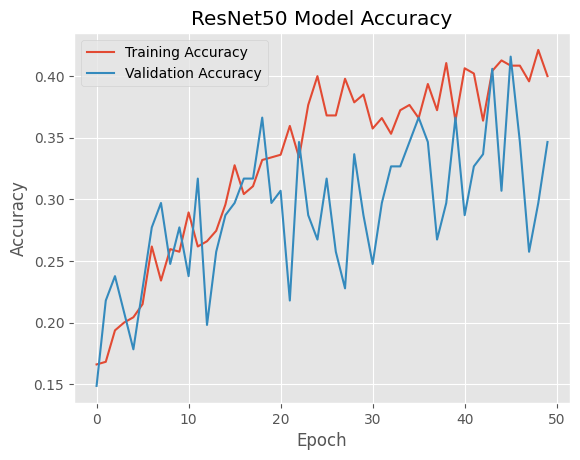

In [ ]:
plt.style.use('ggplot')

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Plot Loss Over Training in Training vs. Validation Sample

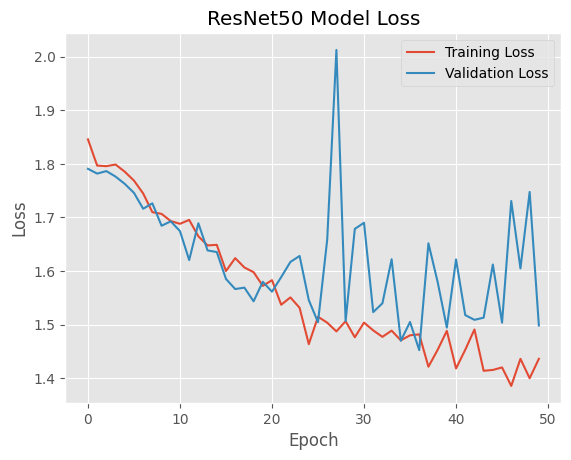

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## ResNet50 Model Evaluation


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━

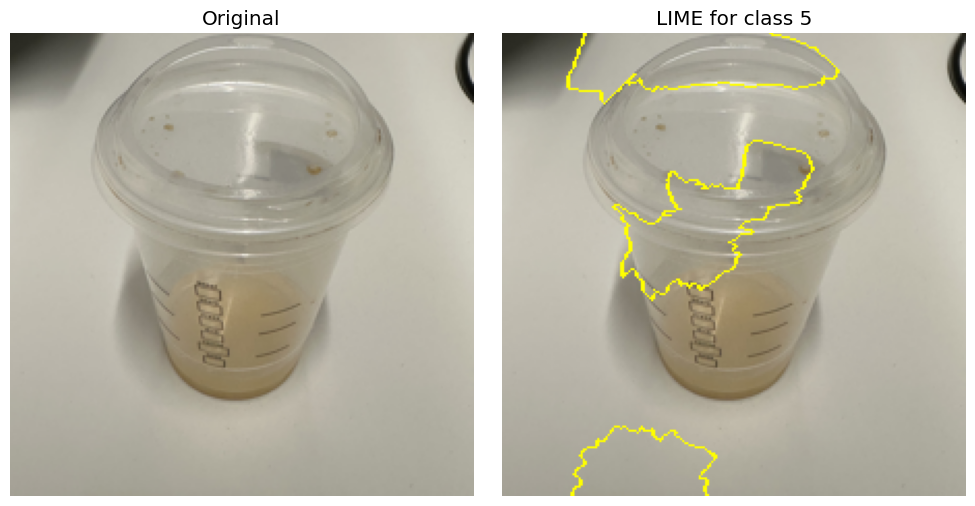

In [ ]:
# Load any model
model = keras.models.load_model('/content/drive/MyDrive/BA 865 Project/resnet50.h5')

# Call the explanation function and display the result
fig = explain_with_lime(
    model,
    img_path=base_dir + '/test3.jpeg',
    image_size=(224, 224),
    top_labels=1,
    hide_color=0,
    num_samples=500,
    num_features=5
)
fig.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Plastic, Confidence: 28.20%


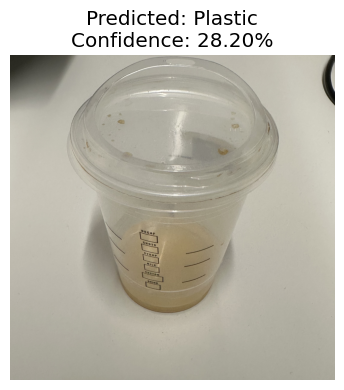

In [ ]:
# Parameter settings
MODEL_PATH  = "/content/drive/MyDrive/BA 865 Project/resnet50.h5"
CLASS_NAMES = ['General Waste','Glass','Metal','Organic Waste','Paper','Plastic']
IMG_PATH    = "/content/drive/MyDrive/BA 865 Project/test3.jpeg"

# Load the model
model = keras.models.load_model(MODEL_PATH)

# Call the prediction function
fig, pred_label, confidence = predict_and_plot(
    model=model,
    img_path=IMG_PATH,
    class_names=CLASS_NAMES,
    img_size=(224,224),
    normalize=True
)

# Display the figure
fig.show()

# Use the prediction result in the program
print(f"Predicted class: {pred_label}, Confidence: {confidence:.2%}")

# Pretrained Model - MobileNetV2 without cutmix

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- Basic settings ---
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 6
AUTOTUNE = tf.data.AUTOTUNE
base_dir = "/content/drive/MyDrive/BA 865 Project"

# --- Load datasets ---
train_dataset_raw = keras.utils.image_dataset_from_directory(
    base_dir + "/train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
val_dataset_raw = keras.utils.image_dataset_from_directory(
    base_dir + "/validation",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# --- Preprocessing ---
def preprocess_image(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

train_dataset = train_dataset_raw.map(preprocess_image).cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_dataset = val_dataset_raw.map(preprocess_image).cache().prefetch(AUTOTUNE)

# --- Data Augmentation ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

# --- Model definition ---
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

base_model = keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

x = base_model(x, training=False)
x = layers.Conv2D(filters=32, kernel_size=3, padding="same",activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, padding="same",activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3 ,padding="same",activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)


model = keras.Model(inputs=inputs, outputs=outputs)

# --- Compile model ---
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# --- Model summary ---
model.summary()

# --- Training ---
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset
)

# --- Save model ---
model.save('/content/drive/MyDrive/BA 865 Project/mobilenetv2.h5')

Found 470 files belonging to 6 classes.
Found 101 files belonging to 6 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,736,294 (10.44 MB)

 Trainable params: 478,310 (1.82 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.3559 - loss: 1.7227 - val_accuracy: 0.3267 - val_loss: 1.9714
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5081 - loss: 1.3337 - val_accuracy: 0.7426 - val_loss: 0.7817
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6721 - loss: 0.8339 - val_accuracy: 0.7327 - val_loss: 0.7503
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.7643 - loss: 0.6166 - val_accuracy: 0.7624 - val_loss: 0.6916
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8602 - loss: 0.4165 - val_accuracy: 0.7327 - val_loss: 0.7308
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8620 - loss: 0.3934 - val_accuracy: 0.8317 - val_loss: 0.5599
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8957 - loss: 0.3046 - val_accuracy: 0.7723 - val_loss: 0.6609
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8845 - loss: 0.3544 - val_accuracy: 0.7525 -

## Plot Accuracy Over Training in Training vs. Validation Sample

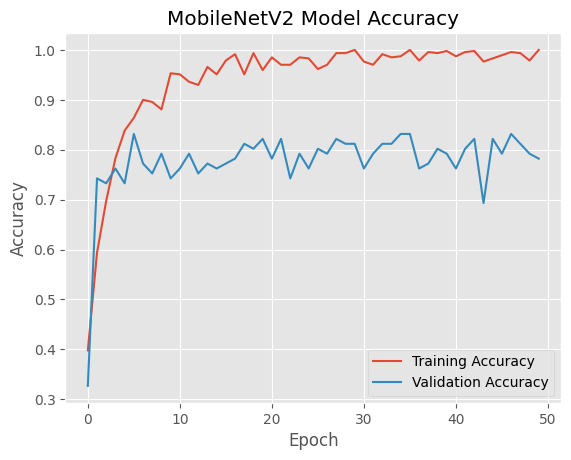

In [ ]:
plt.style.use('ggplot')

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV2 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Plot Loss Over Training in Training vs. Validation Sample

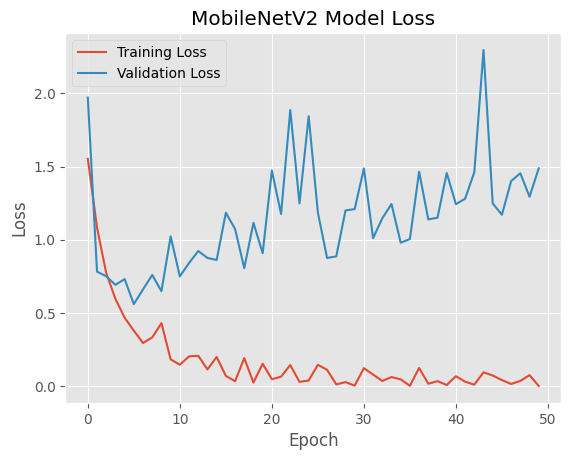

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## MobileNetV2 Without CutMix Evaluation

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━

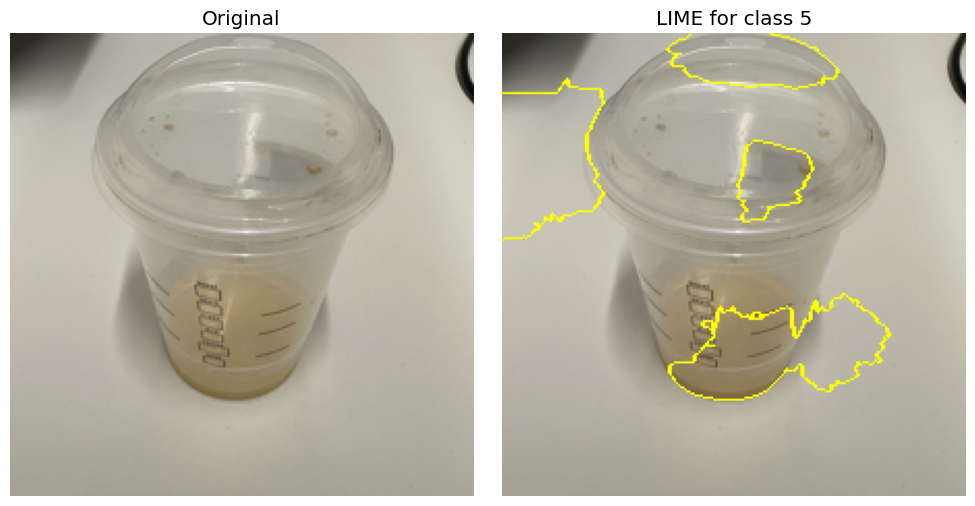

In [ ]:
# Load any model
model = keras.models.load_model('/content/drive/MyDrive/BA 865 Project/mobilenetv2.h5')

# Call the function and display the result
fig = explain_with_lime(
    model,
    img_path=base_dir + '/test3.jpeg',
    image_size=(224, 224),
    top_labels=1,
    hide_color=0,
    num_samples=500,
    num_features=5
)
fig.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Plastic, Confidence: 69.31%


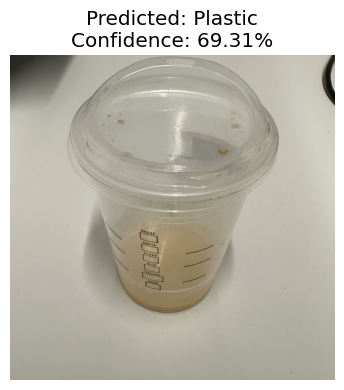

In [ ]:
# Parameter settings
MODEL_PATH  = "/content/drive/MyDrive/BA 865 Project/mobilenetv2.h5"
CLASS_NAMES = ['General Waste', 'Glass', 'Metal', 'Organic Waste', 'Paper', 'Plastic']
IMG_PATH    = "/content/drive/MyDrive/BA 865 Project/test3.jpeg"

# Load the model
model = keras.models.load_model(MODEL_PATH)

# Call the function
fig, pred_label, confidence = predict_and_plot(
    model=model,
    img_path=IMG_PATH,
    class_names=CLASS_NAMES,
    img_size=(224, 224),
    normalize=True
)

# Display the figure
fig.show()

# To use the prediction results in the program
print(f"Predicted Class: {pred_label}, Confidence: {confidence:.2%}")

# Pretrained Model - MobileNetV2 with CutMix

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

# --- Basic settings ---
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 6
AUTOTUNE = tf.data.AUTOTUNE
base_dir = "/content/drive/MyDrive/BA 865 Project"

# Accelerate data loading
train_dataset_raw = tf.keras.utils.image_dataset_from_directory(
    base_dir + "/train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
val_dataset_raw = tf.keras.utils.image_dataset_from_directory(
    base_dir + "/validation",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# --- Preprocessing ---
def preprocess_image(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

train_dataset = train_dataset_raw.map(preprocess_image).cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_dataset = val_dataset_raw.map(preprocess_image).cache().prefetch(AUTOTUNE)

# --- Data Augmentation ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

# --- CutMix with sparse labels ---
def cutmix(image_batch, label_batch):
    batch_size = tf.shape(image_batch)[0]
    # 1. Shuffle within batch
    indices = tf.random.shuffle(tf.range(batch_size))
    shuffled_images = tf.gather(image_batch, indices)
    shuffled_labels = tf.gather(label_batch, indices)

    # 2. Sample mix ratio and box size
    lam = tf.random.uniform((), 0.3, 0.7)
    cut_rat = tf.math.sqrt(1 - lam)
    cut_w = tf.cast(IMG_SIZE * cut_rat, tf.int32)
    cut_h = tf.cast(IMG_SIZE * cut_rat, tf.int32)

    # 3. Random box center
    cx = tf.random.uniform((), 0, IMG_SIZE, dtype=tf.int32)
    cy = tf.random.uniform((), 0, IMG_SIZE, dtype=tf.int32)
    x1 = tf.clip_by_value(cx - cut_w // 2, 0, IMG_SIZE)
    y1 = tf.clip_by_value(cy - cut_h // 2, 0, IMG_SIZE)
    x2 = tf.clip_by_value(cx + cut_w // 2, 0, IMG_SIZE)
    y2 = tf.clip_by_value(cy + cut_h // 2, 0, IMG_SIZE)

    # 4. Create a binary mask of shape (batch, IMG_SIZE, IMG_SIZE, 3)
    patch = tf.ones((batch_size, y2-y1, x2-x1, 3), dtype=tf.float32)
    mask = tf.pad(patch,
                  [[0, 0],
                   [y1, IMG_SIZE - y2],
                   [x1, IMG_SIZE - x2],
                   [0, 0]])

    # 5. Mix images
    mixed_images = image_batch * (1 - mask) + shuffled_images * mask

    return mixed_images, label_batch

# Apply CutMix during training using a map function
train_dataset = train_dataset.map(cutmix, num_parallel_calls=AUTOTUNE)

# --- Model definition ---
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet")
base_model.trainable = False

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3 ,padding="same", activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)

# --- Compile model ---
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# --- Model summary ---
model.summary()

# --- Training ---
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50
)

# --- Save model ---
model.save('/content/drive/MyDrive/BA 865 Project/mobilenetv2_cutmix.h5')

Found 470 files belonging to 6 classes.
Found 101 files belonging to 6 classes.


Model: "functional_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,736,294 (10.44 MB)

 Trainable params: 478,310 (1.82 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.1684 - loss: 1.8941 - val_accuracy: 0.4257 - val_loss: 1.4786
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.3040 - loss: 1.6774 - val_accuracy: 0.5347 - val_loss: 1.3805
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.4209 - loss: 1.5004 - val_accuracy: 0.5050 - val_loss: 1.2528
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.4503 - loss: 1.4397 - val_accuracy: 0.6436 - val_loss: 1.0605
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5126 - loss: 1.3496 - val_accuracy: 0.7822 - val_loss: 0.9747
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5660 - loss: 1.2348 - val_accuracy: 0.6634 - val_loss: 0.9220
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5079 - loss: 1.2506 - val_accuracy: 0.6931 - val_loss: 0.8465
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5026 - loss: 1.2424 - val_accuracy: 0.6931 -

## Plot Accuracy Over Training in Training vs. Validation Sample

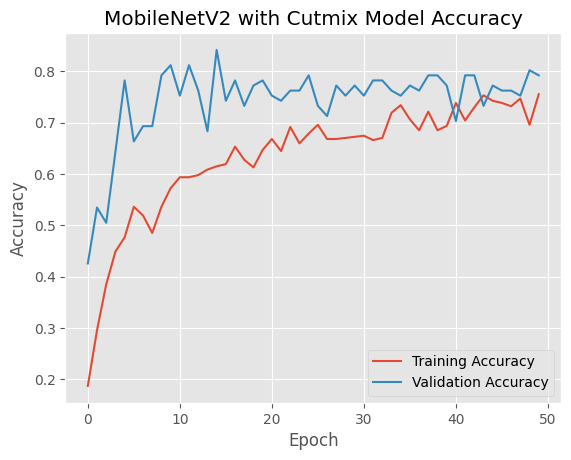

In [ ]:
plt.style.use('ggplot')

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV2 with Cutmix Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Plot Loss Over Training in Training vs. Validation Sample

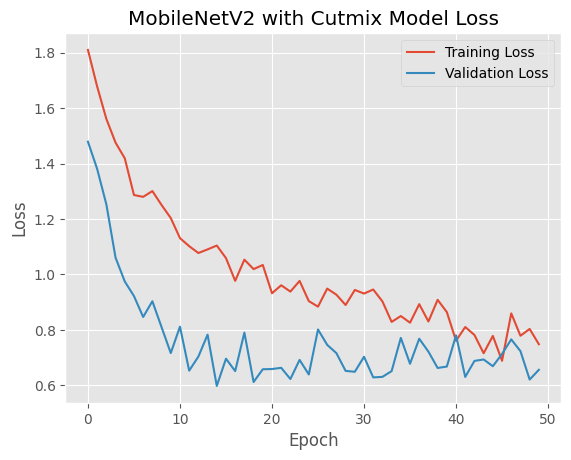

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 with Cutmix Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## MobileNetV2 with CutMix Evaluation

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━

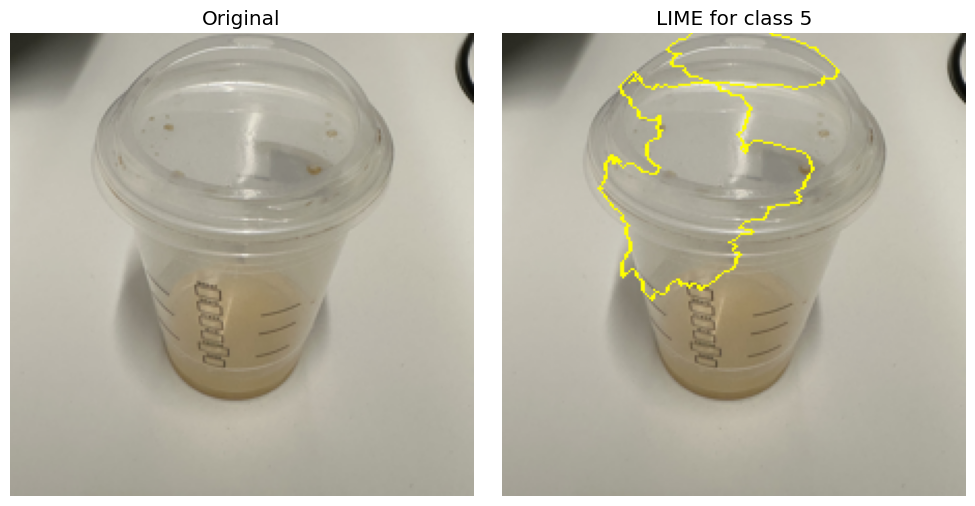

In [ ]:
# Load any model
model = keras.models.load_model('/content/drive/MyDrive/BA 865 Project/mobilenetv2_cutmix.h5')

# Call the function and display the result
fig = explain_with_lime(
    model,
    img_path=base_dir + '/test3.jpeg',
    image_size=(224, 224),
    top_labels=1,
    hide_color=0,
    num_samples=500,
    num_features=5
)
fig.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: Plastic, Confidence: 86.85%


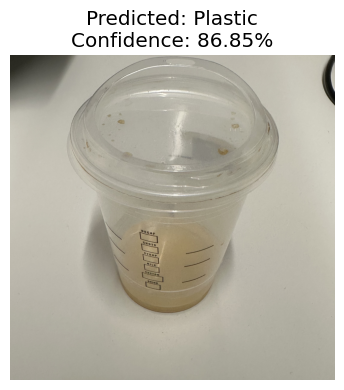

In [ ]:
# Parameter settings
MODEL_PATH  = "/content/drive/MyDrive/BA 865 Project/mobilenetv2_cutmix.h5"
CLASS_NAMES = ['General Waste', 'Glass', 'Metal', 'Organic Waste', 'Paper', 'Plastic']
IMG_PATH    = "/content/drive/MyDrive/BA 865 Project/test3.jpeg"

# Load model
model = keras.models.load_model(MODEL_PATH)

# Call the function
fig, pred_label, confidence = predict_and_plot(
    model=model,
    img_path=IMG_PATH,
    class_names=CLASS_NAMES,
    img_size=(224,224),
    normalize=True
)

# Display the figure
fig.show()

# If you want to use the prediction result in the program
print(f"Predicted class: {pred_label}, Confidence: {confidence:.2%}")

# Test Set Evaluation

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

test_dataset = image_dataset_from_directory(
    base_dir + "/test/",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    seed=100
)

CLASS_NAMES = ['General Waste', 'Glass', 'Metal', 'Organic Waste', 'Paper', 'Plastic']

def preprocess_image(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

test_dataset = test_dataset.map(preprocess_image).cache().prefetch(tf.data.AUTOTUNE)

models = {
    'Self-Built1': load_model('/content/drive/MyDrive/BA 865 Project/bestv1.h5'),
    'Self-Built2': load_model('/content/drive/MyDrive/BA 865 Project/bestv2.h5'),
    'Self-Built3': load_model('/content/drive/MyDrive/BA 865 Project/bestv3.h5'),
    'Self-Built4': load_model('/content/drive/MyDrive/BA 865 Project/bestv4.h5'),
    'ResNet50': load_model('/content/drive/MyDrive/BA 865 Project/resnet50.h5'),
    'MobileNetV2': load_model('/content/drive/MyDrive/BA 865 Project/mobilenetv2.h5'),
    'MobileNetV2-cutmix': load_model('/content/drive/MyDrive/BA 865 Project/mobilenetv2_cutmix.h5')
}

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"{model_name} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    y_true = []
    y_pred = []
    for images, labels in test_dataset:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))

    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
    print(f"Confusion Matrix for {model_name}:")
    print(confusion_matrix(y_true, y_pred))

Found 106 files belonging to 6 classes.


Evaluating Self-Built1...
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.6531 - loss: 1.2424
Self-Built1 - Test Loss: 1.3305, Test Accuracy: 0.6509
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Classification Report for Self-Built1:
               precision    recall  f1-score   support

General Waste       0.48      0.55      0.51        20
        Glass       0.93      0.81      0.87        16
        Metal       0.55      0.61      0.58        18
Organic Waste       0.70      0.84      0.76        19
        Paper       0.75      0.60      0.67        15
      Plastic       0.64      0.50      0.56        18

     accuracy                           0.65       106
    macro avg       0.67      0.65      0.66       106
 weighted avg       0.66      0.65      0.65       106

Confusion Matrix for Self-Built1:
[[11  0  3  2  1  3]
 [ 0 13  2  1  0  0]
 [ 4  0 11  1  0  2]
 [ 1  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Classification Report for Self-Built2:
               precision    recall  f1-score   support

General Waste       0.46      0.55      0.50        20
        Glass       0.92      0.75      0.83        16
        Metal       0.57      0.67      0.62        18
Organic Waste       0.76      0.84      0.80        19
        Paper       0.67      0.53      0.59        15
      Plastic       0.73      0.61      0.67        18

     accuracy                           0.66       106
    macro avg       0.69      0.66      0.67       106
 weighted avg       0.68      0.66      0.66       106

Confusion Matrix for Self-Built2:
[[11  0  3  3  1  2]
 [ 0 12  4  0  0  0]
 [ 3  0 12  1  0  2]
 [ 1  0  1 16  1  0]
 [ 6  1  0  0  8  0]
 [ 3  0  1  1  2 11]]
Evaluating Self-Built3...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7083 - loss: 1.1175 
Self-Built3 - Test Loss: 1.1723, Test Accuracy: 0.7264
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━

# Suggestions and Future Works

Looking ahead, we plan to take several steps to improve our model’s performance:

1. Multi-Object Recognition  
Extend the classifier so it can detect and label multiple waste types within a single image — enabling it to handle complex scenes like mixed recycling bins.
2. Real-Time Edge Inference  
Integrate OpenCV to capture live video frames, then deploy a quantized version of our model on edge devices (e.g. Raspberry Pi). This will deliver low-latency, on-device predictions for instant waste sorting.
3. Expanded Data Collection  
Gather a larger, more diverse dataset — covering different lighting conditions, backgrounds, and waste arrangements — to improve generalization and reduce overfitting.
4. Transformer-Based Architectures  
Experiment with vision transformers such as ViT and DeiT, which have outperformed CNNs on many classification benchmarks. Fine-tuning these models could unlock additional accuracy gains.
5. Model Ensembles  
Combine the top-performing architectures (e.g. MobileNetV2 + CutMix, fine-tuned ResNet50, EfficientNet-Lite) via simple averaging or weighted voting to stabilize and often improve overall accuracy.